# Bank Marketing
In this notebook, the goal is to create a propensity model, which is essentially a classification model.
This model aims to detect whether the client will subscribe to the marketing campaign or not.  
  
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.  
  
This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).  
  
The binary classification goal is to predict if the client will subscribe a bank term deposit (variable y).


# Input variables:
## bank client data:
| Column | Type | Description |
|---|---|---|
| age | numeric | client age |
| job | categorical | type of job ("admin.","blue-collar", ..., "unemployed","unknown")|
| marital | categorical | marital status ("divorced","married","single","unknown"; note: "divorced" means divorced or widowed) |
| education | categorical | level of education ("basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown") |
| default | categorical | has credit in default? ("no","yes","unknown") |
| housing | categorical | has housing loan? ("no","yes","unknown")   |
| loan | categorical | has personal loan?("no","yes","unknown") |
| contact | categorical | contact communication type ("cellular","telephone") |
| month | categorical | last contact month of year ("jan", "feb", "mar", ..., "nov", "dec")   |
| day_of_week | categorical | last contact day of the week ("mon","tue","wed","thu","fri")  |
| duration | numeric | last contact duration in seconds. Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model |
| campaign | numeric | number of contacts performed during this campaign and for this client |
| pdays | numeric | number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| previous | numeric | number of contacts performed before this campaign and for this client |
| poutcome | categorical | outcome of the previous marketing campaign ("failure","nonexistent",  "success") |
| emp.var.rate | numeric | employment variation rate - quarterly indicator |
| cons.price.idx | numeric | consumer price index - monthly indicator |
| cons.conf.idx | numeric | consumer confidence index - monthly indicator  |
| euribor3m | numeric | euribor 3 month rate - daily indicator |
| nr.employed | numeric | number of employees - quarterly indicator |
| y (target) | binary | has the client subscribed a term deposit? ("yes","no") |
  
OBS: Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques.

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from helper_functions.plots import make_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

# 1. Loading Data

In [2]:
dataset_path = "../datasets/bank_marketing/bank-additional/bank-additional-full.csv"
df = pd.read_csv(dataset_path, sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


OBS: The column duration will not be used.  
We will work with the following numeric columns:

In [3]:
numeric_columns = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]
df[numeric_columns].head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0


We will work with the following categorical columns:

In [4]:
categorical_columns = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]
df[categorical_columns].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


# 2. EDA (Exploratory Data Analysis)

In this dataset, missing data was replaced with unknown. To visualize it, we will substitute unknown with np.nan and use the missingno library to get a visual representation of the missing values in our dataset.

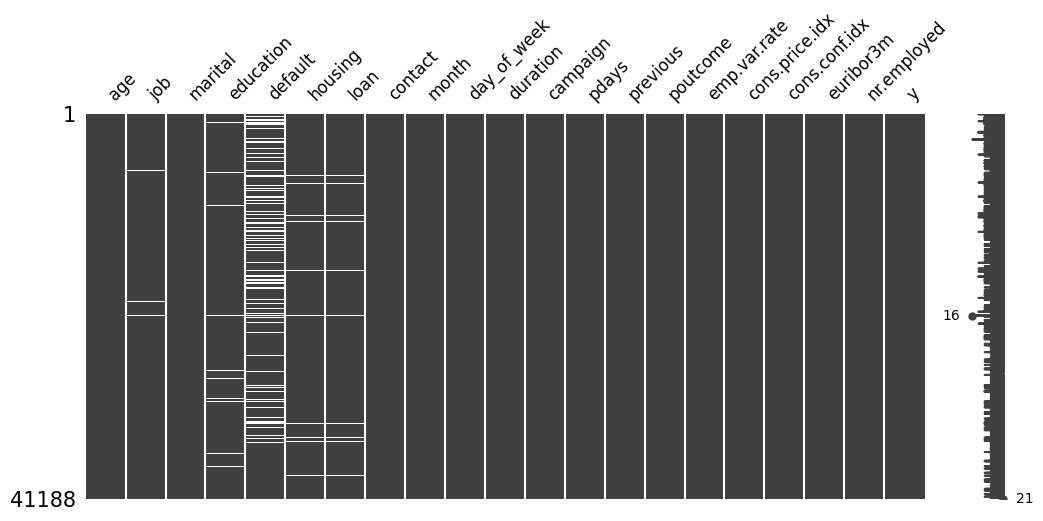

In [5]:
msno.matrix(df.replace("unknown", np.nan), figsize=(12, 5), fontsize=12)
plt.show()

In [6]:
df[numeric_columns].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Next, we will plot the distribution of the categories of the categorical columns and the target in a bar chart.

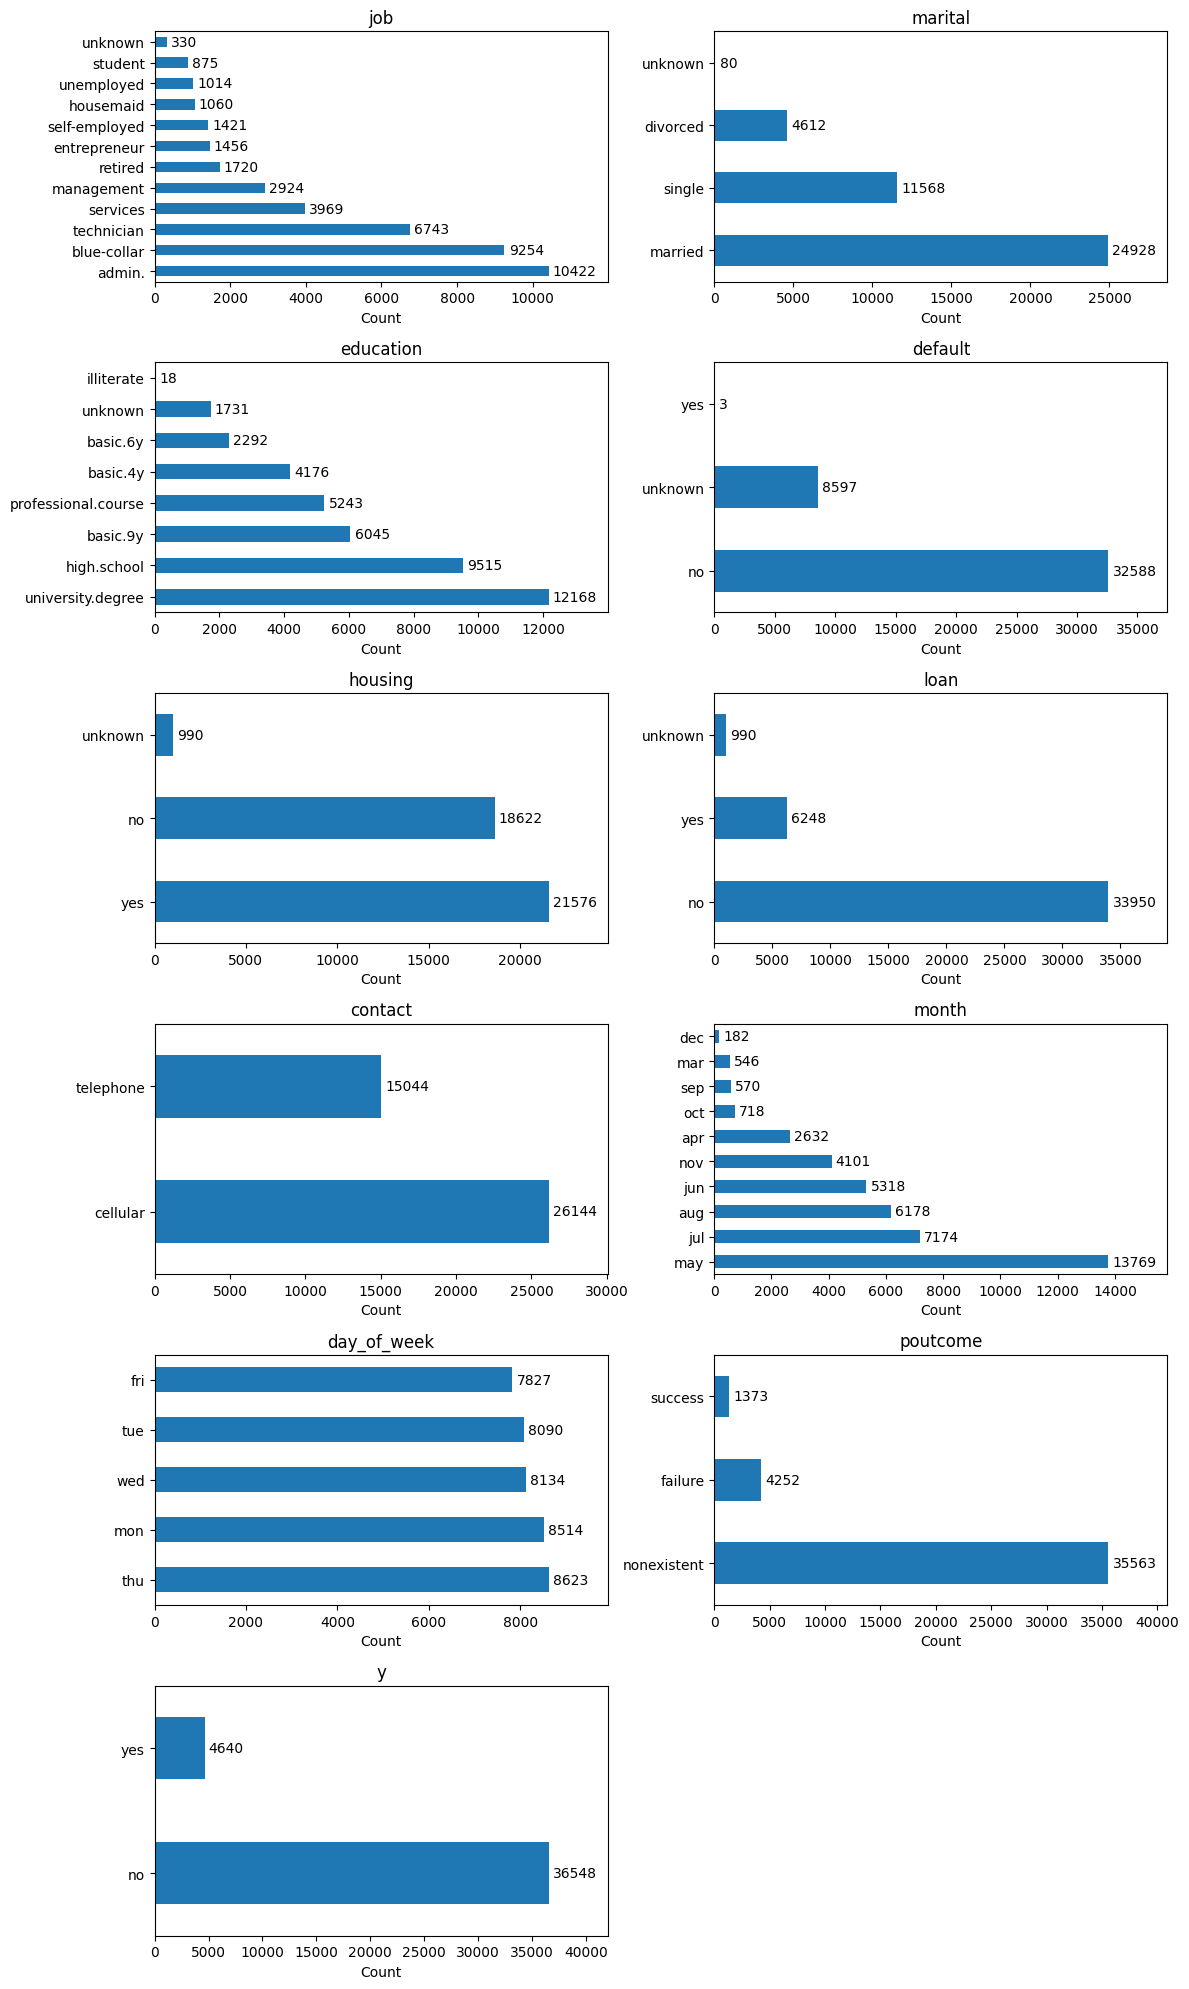

In [19]:
columns = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
    "y",
]

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 20))
axes = axes.flatten()

for idx, col in enumerate(columns):
    ax = axes[idx]
    df[col].value_counts(dropna=False).plot(kind="barh", ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Count")
    ax.set_ylabel("")

    for container in ax.containers:
        ax.bar_label(container, fmt="%d", label_type="edge", padding=3)

    max_count = df[col].value_counts(dropna=False).max()
    ax.set_xlim(right=max_count * 1.15)

for j in range(len(columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

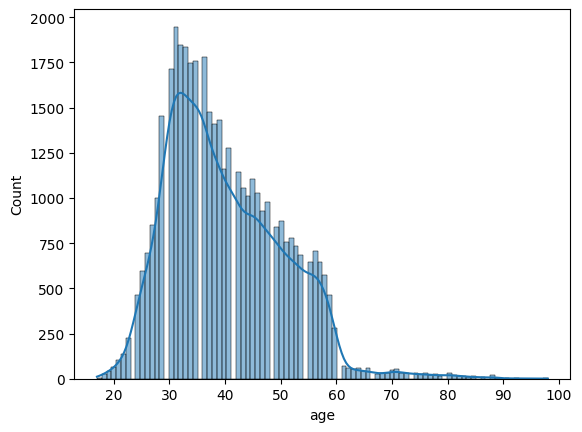

In [20]:
sns.histplot(data=df, x="age", kde=True)
plt.show()

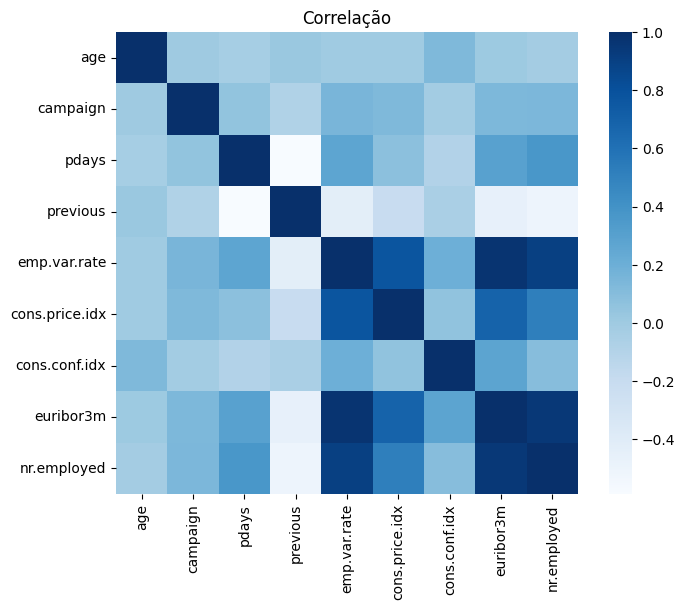

In [21]:
corr_df = df[numeric_columns].corr(method="pearson")

fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Correlação")
sns.heatmap(
    data=corr_df,
    mask=np.zeros_like(corr_df, dtype=np.bool),
    cmap="Blues",
    square=True,
    ax=ax,
)
plt.show()

# 3. Preprocessing

In [10]:
def encoder_categorical(df: pd.DataFrame, categorical_columns: list[str]) -> np.ndarray:
    ohe_model = OneHotEncoder()
    result = ohe_model.fit_transform(df[categorical_columns])

    return result.toarray(), ohe_model


def encoder_numeric(df: pd.DataFrame, numeric_columns: list[str]) -> np.ndarray:
    return df[numeric_columns].to_numpy()


def encoder_df(df: pd.DataFrame, categorical_columns: list[str], numeric_columns: list[str]) -> np.ndarray:
    ohe_array, _ = encoder_categorical(df, categorical_columns)
    nc_array = encoder_numeric(df, numeric_columns)

    encoded_array = np.concatenate((ohe_array, nc_array), axis=1)

    return encoded_array

In [11]:
encoded_df = encoder_df(df.reset_index(drop=True), categorical_columns, numeric_columns)
print(encoded_df.shape)

(41188, 63)


In [12]:
encoded_df

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -3.6400e+01,
         4.8570e+00,  5.1910e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -3.6400e+01,
         4.8570e+00,  5.1910e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -3.6400e+01,
         4.8570e+00,  5.1910e+03],
       ...,
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -5.0800e+01,
         1.0280e+00,  4.9636e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -5.0800e+01,
         1.0280e+00,  4.9636e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -5.0800e+01,
         1.0280e+00,  4.9636e+03]], shape=(41188, 63))

In [13]:
X = encoded_df

mapping = {"no": 0, "yes": 1}
y = df["y"].map(mapping).to_numpy()

X.shape, y.shape

((41188, 63), (41188,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=7)

In [15]:
models = [
    ("KNN", KNeighborsClassifier()),
    ("RFC", RandomForestClassifier()),
    ("XGB", XGBClassifier()),
    ("CART", DecisionTreeClassifier()),
    ("NB", GaussianNB()),
    # ("LR", LogisticRegression(max_iter=10000)),
    # ("SVM", SVC()),
]

In [16]:
metrics = list()
results = list()
names = list()

for name, model in (pbar := tqdm(models)):
    pbar.set_description(name)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")

    results.append(cv_results)
    names.append(name)
    metrics.append({"name": name, "accuracy": cv_results.mean(), "std": cv_results.std()})

pd.DataFrame(metrics).sort_values(by="accuracy", ascending=False)

NB: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]  


,name,accuracy,std
2,XGB,0.913111,0.006785
1,RFC,0.912777,0.003925
0,KNN,0.904674,0.003334
3,CART,0.890015,0.005400
4,NB,0.865190,0.007082


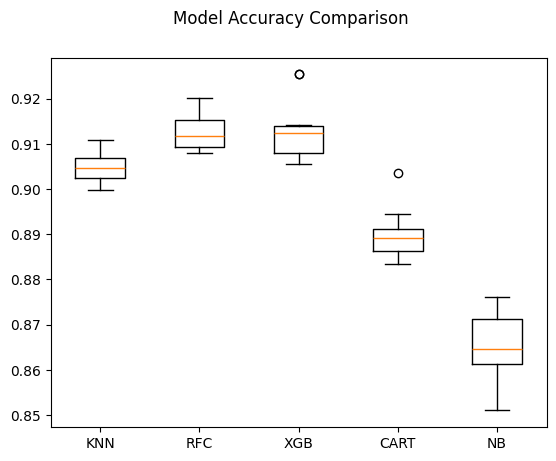

In [17]:
fig = plt.figure()
fig.suptitle("Model Accuracy Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

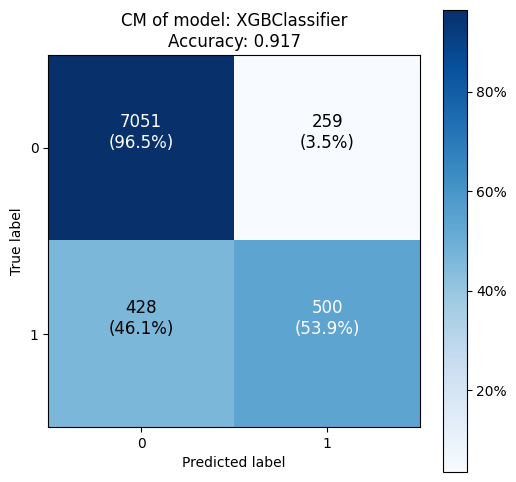

In [18]:
model = XGBClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)

make_confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    # classes=label_encoder.classes_.tolist(),
    figsize=(6, 6),
    text_size=12,
    title=f"CM of model: XGBClassifier\nAccuracy: {acc:.3f}",
)

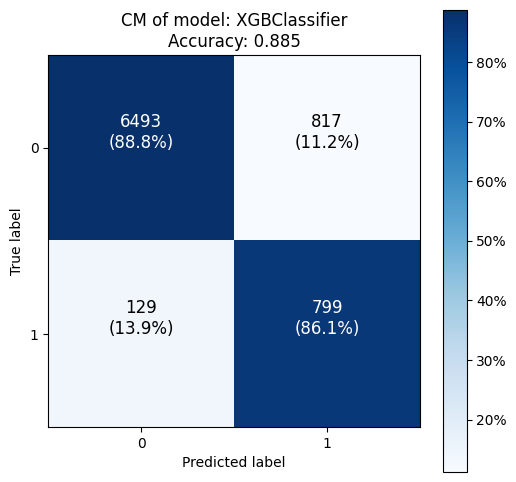

In [19]:
class_weights = {0: 1, 1: 10}

pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

model = XGBClassifier(scale_pos_weight=pos_weight)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)

make_confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    # classes=label_encoder.classes_.tolist(),
    figsize=(6, 6),
    text_size=12,
    title=f"CM of model: XGBClassifier\nAccuracy: {acc:.3f}",
)

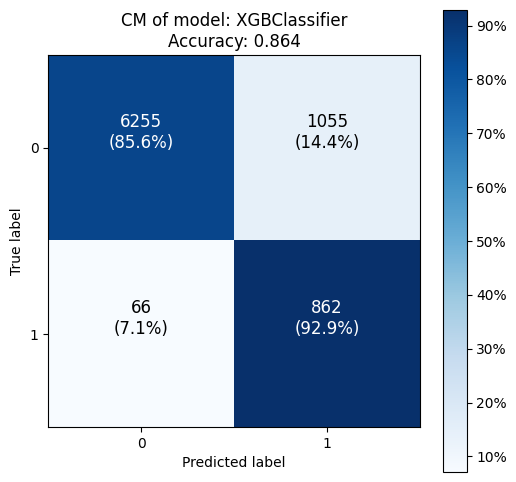

In [20]:
class_weights = {0: 1, 1: 10}

pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

model = XGBClassifier(
    scale_pos_weight=pos_weight,
    learning_rate=0.02,
    n_estimators=600,
    objective="binary:logistic",
    nthread=1,
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)

make_confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    # classes=label_encoder.classes_.tolist(),
    figsize=(6, 6),
    text_size=12,
    title=f"CM of model: XGBClassifier\nAccuracy: {acc:.3f}",
)

In [21]:
class_weights = {0: 1, 1: 10}

pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

model = XGBClassifier(
    scale_pos_weight=pos_weight,
    learning_rate=0.02,
    n_estimators=600,
    objective="binary:logistic",
    nthread=6,
)

In [22]:
param_grid = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
}

In [23]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

,estimator,"XGBClassifier...thread=6, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0.5, 1, ...], 'max_depth': [3, 4, ...], 'min_child_weight': [1, 5, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [24]:
CV_rfc.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

In [ ]:
class_weights = {0: 1, 1: 10}

pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

model = XGBClassifier(
    scale_pos_weight=pos_weight,
    learning_rate=0.02,
    n_estimators=600,
    objective="binary:logistic",
    nthread=1,
    min_child_weight=CV_rfc.best_params_["min_child_weight"],
    gamma=CV_rfc.best_params_["gamma"],
    subsample=CV_rfc.best_params_["subsample"],
    colsample_bytree=CV_rfc.best_params_["colsample_bytree"],
)

In [25]:
# class_weights = {0: 1, 1: 10}

# pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

# model = XGBClassifier(
#     scale_pos_weight=pos_weight,
#     learning_rate=0.02,
#     n_estimators=600,
#     objective="binary:logistic",
#     nthread=1,
#     min_child_weight=1,
#     gamma=1.5,
#     subsample=0.6,
#     colsample_bytree=1.0,
#     max_depth=5,
# )

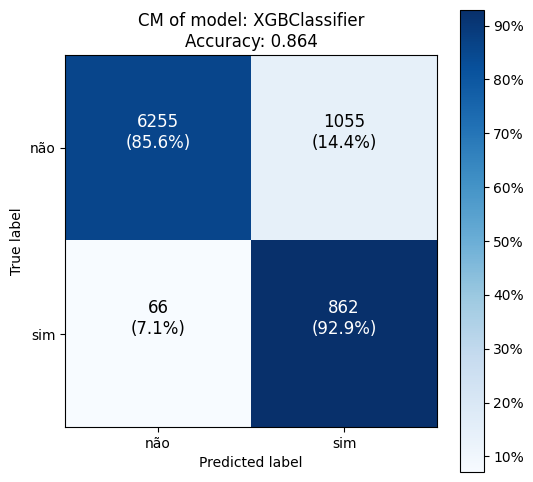

In [26]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)

make_confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    classes=["não", "sim"],
    figsize=(6, 6),
    text_size=12,
    title=f"CM of model: XGBClassifier\nAccuracy: {acc:.3f}",
)

In [27]:
print(classification_report(y_true=y_test, y_pred=predictions))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.45      0.93      0.61       928

    accuracy                           0.86      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.86      0.88      8238



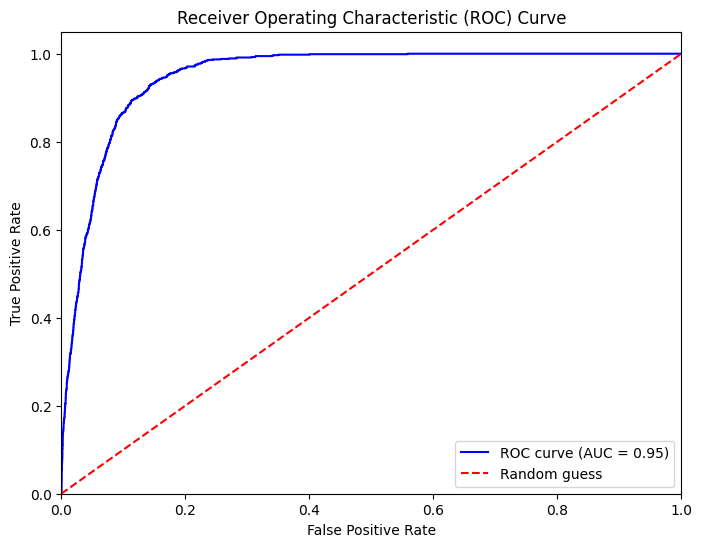

In [28]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_test, y_pred_proba)

0.9501671634466907

In [38]:
model.predict(X_test)

array([0, 1, 0, ..., 0, 0, 1], shape=(8238,))

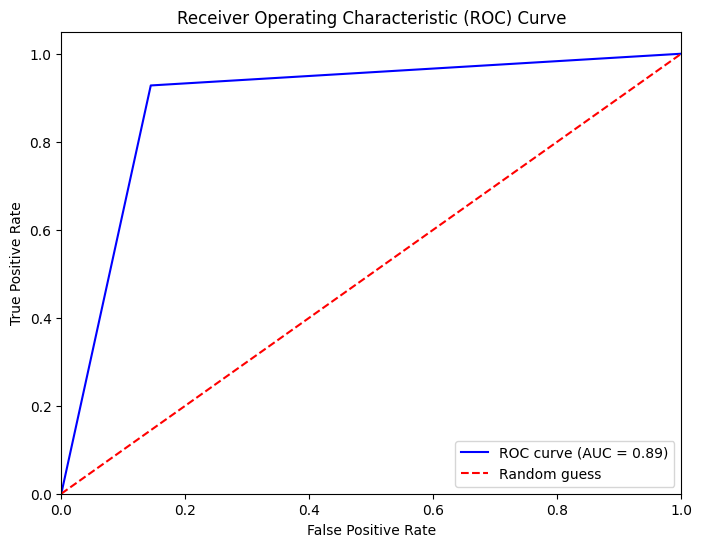

In [39]:
y_pred = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Melhorias
- pipeline (https://scikit-learn.org/stable/auto_examples/preprocessing/plot_target_encoder.html#training-and-evaluating-pipelines-with-different-encoders)
- tratar variáveis numéricas, talvez algo na linha do MinMaxScaler